In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import os
import sys
sys.path.append("../code/extinction_analysis/")
from analysis_utils import generate_network_extinction_simulations, All_networks_extinction_analysis

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
working_dir = "../data/statistical_analysis/extinction_analysis/"
extinction_simluations_output_path = f"{working_dir}united_extinction_simulations.csv"
weighted_features_data = "../data/features/plant_features/weighted/features_with_classification.csv"
weighted_networks_path = "../data/networks/all/weighted/"
binary_features_data = "../data/features/plant_features/binary/features_with_classification.csv"
binary_networks_path = "../data/networks/all/binary/"
binarized_features_data = "../data/features/plant_features/binarized_weighted/features_with_classification.csv"
binarized_networks_path = "../data/networks/all/binarized_weighted/"
networks = {'weighted': {'networks': weighted_networks_path, 'data': weighted_features_data},
            'binary': {'networks': binary_networks_path, 'data': binary_features_data},
            'binarized_weighted': {'networks': binarized_networks_path, 'data': binarized_features_data}}
rates_ranges_options = [[0.6, 1],  [0.3, 0.6],  [0, 0.3],]
sim_num = 100

# conduct extrinction analyses across all networks

In [3]:
if not os.path.exists(extinction_simluations_output_path):
    inputs_for_exec = pd.DataFrame(columns=["network_path", "classifications_path", "rate_range", "num_sim", "output_path"])
    for _type in networks:
        for r in range(len(rates_ranges_options)):
            range_option = rates_ranges_options[r]
            networks_dir = networks[_type]["networks"]
            output_dir = f"{working_dir}/{_type}/range_option_{r}/"
            os.makedirs(output_dir, exist_ok=True)
            classification_path = networks[_type]["data"]
            for path in os.listdir(networks_dir):
                if path == ".ipynb_checkpoints":
                    continue
                network_path = f"{networks_dir}{path}"
                output_path = f"{output_dir}/extinction_simulations_network_{path}"
                if not os.path.exists(output_path):
                    inputs_for_exec = pd.concat([inputs_for_exec, pd.DataFrame({"network_path": [network_path],
                                                                   "classifications_path": [classification_path],
                                                                   "rate_range": [range_option],
                                                                   "num_sim": [sim_num],                                                                
                                                                   "output_path": [output_path]})])
    print(f"# tasks =  {inputs_for_exec.shape[0]:,}")         
    if inputs_for_exec.shape[0] > 0:
        inputs_for_exec.parallel_apply(lambda record: generate_network_extinction_simulations(network_path=record.network_path,
                                                            network_species_metedata_path=record.classifications_path,
                                                            output_path=record.output_path,
                                                            polyploid_range=record.rate_range, 
                                                            diploid_range=record.rate_range, 
                                                            unknown_range=record.rate_range, 
                                                            pollinator_range=record.rate_range, 
                                                            iter=sim_num), axis=1)
    extinction_simulations = []
    for _type in networks:
        for r in range(len(rates_ranges_options)):
            range_option = rates_ranges_options[r]
            networks_dir = networks[_type]["networks"]
            output_dir = f"{working_dir}/{_type}/range_option_{r}/"
            datasets_simulations = []
            for path in os.listdir(output_dir):
                network_index = int(path.split("_")[-1].replace(".csv",""))
                simulations = pd.read_csv(f"{output_dir}/{path}")
                simulations["network"] = network_index
                datasets_simulations.append(simulations)
            print(f"# datasets with simulations for networks of type {_type} and range option {range_option} = {len(datasets_simulations):,}")
            all_simulations = pd.concat(datasets_simulations)
            all_simulations["network_type"] = _type
            all_simulations["rate_range"] = str(tuple(range_option))
            extinction_simulations.append(all_simulations)
    extinction_simulations = pd.concat(extinction_simulations)
    extinction_simulations.to_csv(extinction_simluations_output_path)
else:
    extinction_simulations = pd.read_csv(extinction_simluations_output_path)

# analyze networks

## process data

In [6]:
extinction_simulations.sort_values(["network_type", "rate_range", "network", "simulation_index", "degree"], inplace=True)
extinction_simulations.rename(columns={"degree": "iteration"}, inplace=True)

In [9]:
extinction_simulations["baseline_n_unknown"] = extinction_simulations.baseline_n_plant - extinction_simulations.baseline_n_diploids - extinction_simulations.baseline_n_polyploids
extinction_simulations["baseline_percent_polyploids"] = extinction_simulations["baseline_n_polyploids"] / (extinction_simulations["baseline_n_diploids"]+extinction_simulations["baseline_n_polyploids"])
extinction_simulations["baseline_percent_unknown"] = extinction_simulations["baseline_n_unknown"] / extinction_simulations["baseline_n_plant"]

extinction_simulations["current_percent_polyploids"] = extinction_simulations["total_plants_prior_extinction_polyploid"] / (extinction_simulations["total_plants_prior_extinction_diploid"]+extinction_simulations["total_plants_prior_extinction_polyploid"])
extinction_simulations["current_percent_unknown"] = extinction_simulations["total_plants_prior_extinction_unknown"] / extinction_simulations["total_plants_prior_extinction"]

extinction_simulations["max_iteration"] = extinction_simulations.groupby(["network_type",	"rate_range", "network", "simulation_index"]).iteration.transform(np.max)

## filter data

In [10]:
debug_db = extinction_simulations.loc[(extinction_simulations.max_iteration >= 5)  & 
                                      (extinction_simulations.baseline_n_polyploids >= 5) & 
                                      (extinction_simulations.baseline_percent_unknown <= 0.4)]

In [11]:
debug_db_grouped = debug_db.sort_values("iteration").groupby(["network_type", "network", "rate_range", "simulation_index"])
network_to_connectence_diff = debug_db_grouped.connectence.apply(lambda x: x.values[0]-x.values[-1]).to_dict()
debug_db.set_index(["network_type", "network", "rate_range", "simulation_index"], inplace=True)
debug_db["connectence_diff"] = np.nan
debug_db["connectence_diff"].fillna(value=network_to_connectence_diff, inplace=True)
debug_db.reset_index(inplace=True)

In [ ]:
debug_db

In [12]:
debug_db.to_csv(f"{working_dir}/extinction_simulations_for_analysis.csv", index=False)

### bin data

In [13]:
nbins = 3
debug_db["missing_fraction_bin"] = pd.cut(debug_db["baseline_percent_unknown"], bins=nbins)
debug_db["n_plants_bin"] = pd.cut(debug_db["baseline_n_plant"], bins=nbins)
debug_db["percent_polyploids_bin"] = pd.cut(debug_db["baseline_percent_polyploids"], bins=nbins)
debug_db["iterations_bin"] = pd.cut(debug_db["iteration"], bins=nbins)

In [14]:
debug_db_grouped = debug_db.groupby(["missing_fraction_bin", "n_plants_bin", "percent_polyploids_bin", "iterations_bin", "rate_range"]) # "network_type"
debug_db_grouped.ngroups

40

## examine perliminary assumptions

[Text(0.5, 1.0, 'mean connectence diff across all datasets')]

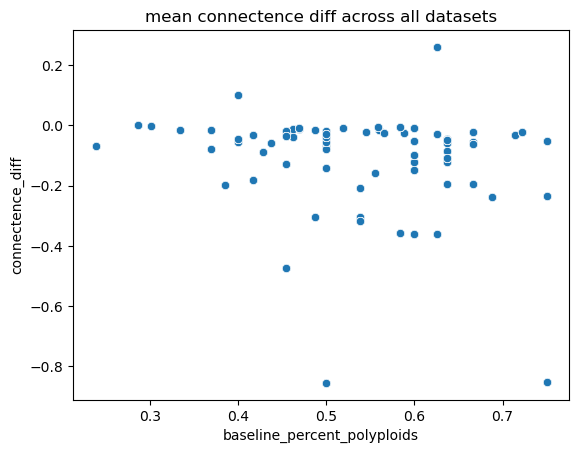

In [15]:
sns.scatterplot(data=debug_db.drop(["iteration"], axis=1).drop_duplicates(), x='baseline_percent_polyploids', y='connectence_diff').set(title="mean connectence diff across all datasets")

[Text(0.5, 1.0, 'mean connectence diff across groups')]

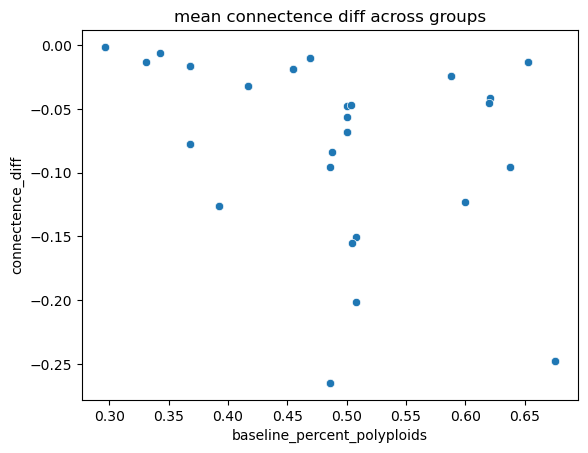

In [16]:
sns.scatterplot(data=debug_db_grouped.mean(), x='baseline_percent_polyploids', y='total_plants_prior_extinction').set(title="mean  diff across groups")

[Text(0.5, 1.0, 'remaining plants diff across all datasets')]

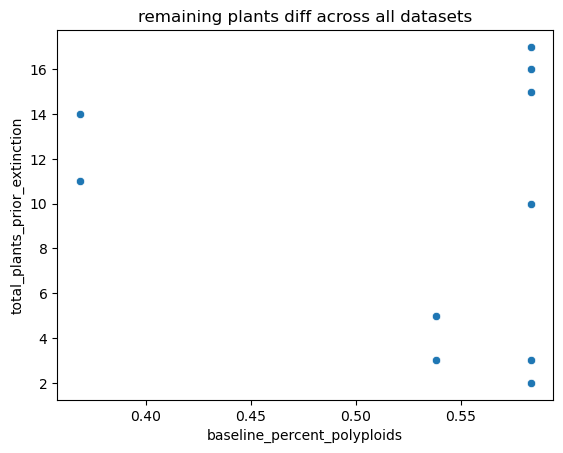

In [74]:
sns.scatterplot(data=debug_db.drop_duplicates(["iteration"], keep="last"), x='baseline_percent_polyploids', y='total_plants_prior_extinction').set(title="remaining plants diff across all datasets")

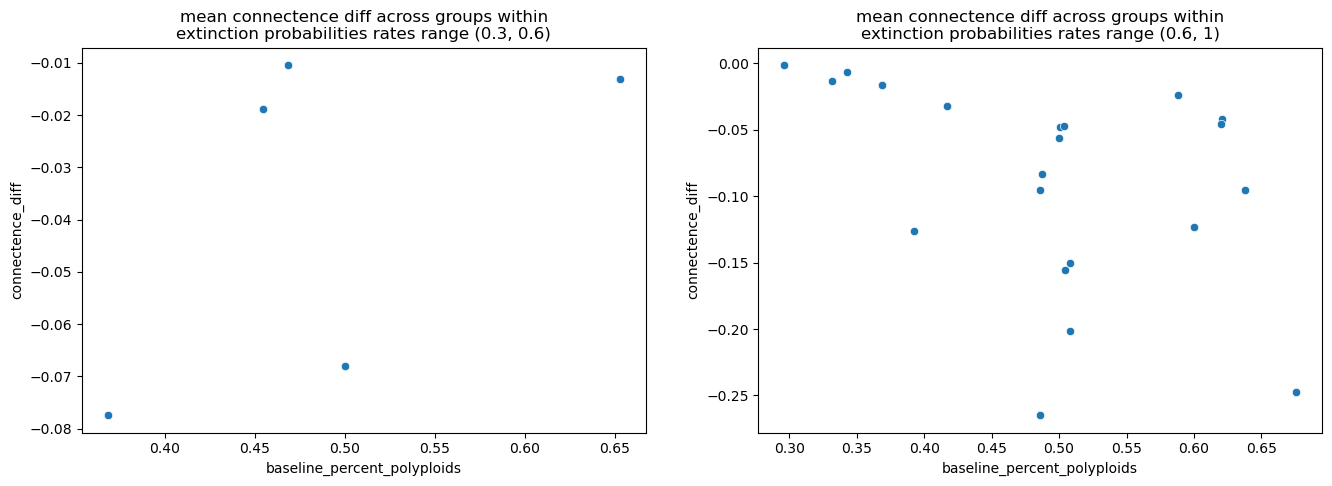

In [17]:
debug_db_by_rate_ranges = debug_db.groupby("rate_range")
groups = list(debug_db_by_rate_ranges.groups.keys())
fig, axes = plt.subplots(nrows=1, ncols=len(groups), figsize=(8*len(groups),5))
for i in range(len(groups)):
    rate_range = groups[i]
    debug_group = debug_db_by_rate_ranges.get_group(rate_range).groupby(["missing_fraction_bin", "n_plants_bin", "percent_polyploids_bin", "iterations_bin", "rate_range"])
    sns.scatterplot(data=debug_group.mean(), x='baseline_percent_polyploids', y='connectence_diff', ax=axes[i]).set(title=f"mean connectence diff across groups within\nextinction probabilities rates range {rate_range}")

In [19]:
debug_db["percent_polyploids_diff"] = debug_db.baseline_percent_polyploids - debug_db.current_percent_polyploids
debug_db_grouped = debug_db.groupby(["network_type", "network", "rate_range", "iteration"]).mean().reset_index()
print(f"# datasets = {debug_db_grouped.drop(['iteration'], axis=1).drop_duplicates().shape[0]:,}")

# datasets = 390


(-0.5, 0.5)

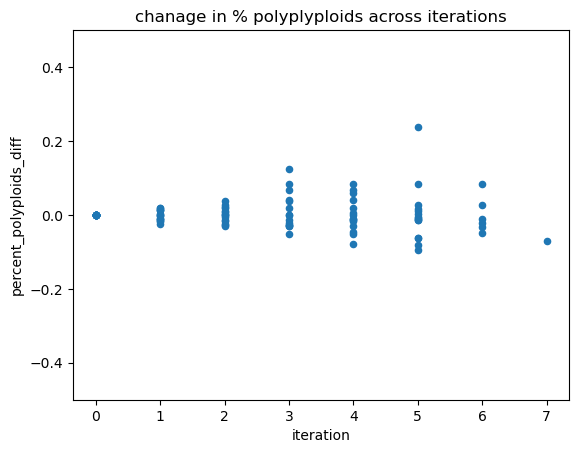

In [28]:
debug_db_grouped.query("max_iteration >= 5 and rate_range == '(0.6, 1)' and baseline_percent_unknown < 0.4 and baseline_n_plant > 20").plot(x="iteration", y="percent_polyploids_diff", kind="scatter")
plt.title("chanage in % polyplyploids across iterations")
plt.ylim(-0.5, 0.5)

Text(0.5, 1.0, 'chanage in #plants across iterations across polyploids-rich networks (>50%)')

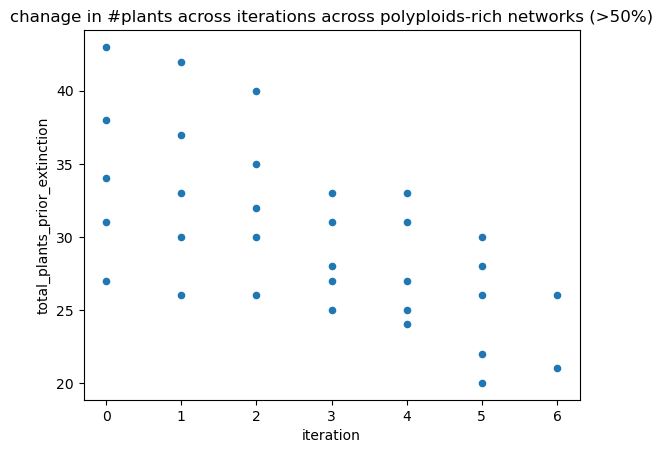

In [80]:
debug_db_grouped.query("max_iteration >= 5 and baseline_percent_polyploids > 0.5 and rate_range == '(0.6, 1)' and baseline_percent_unknown < 0.4 and baseline_n_plant > 20").plot(x="iteration", y="total_plants_prior_extinction", kind="scatter")
plt.title("chanage in #plants across iterations across polyploids-rich networks (>50%)")

Text(0.5, 1.0, 'chanage in #plants across iterations across polyploids-poor networks (<50%)')

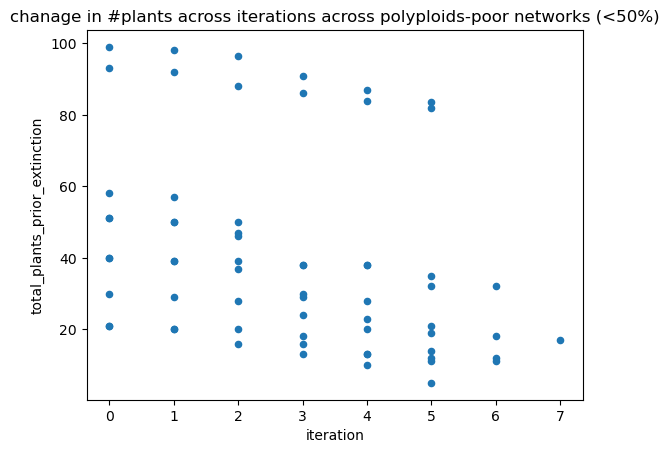

In [79]:
debug_db_grouped.query("max_iteration >= 5 and baseline_percent_polyploids <= 0.5 and rate_range == '(0.6, 1)' and baseline_percent_unknown < 0.4 and baseline_n_plant > 20").plot(x="iteration", y="total_plants_prior_extinction", kind="scatter")
plt.title("chanage in #plants across iterations across polyploids-poor networks (<50%)")

In [65]:
debug_db_grouped.columns

Index(['network_type', 'network', 'rate_range', 'iteration',
       'simulation_index', 'total_pollinator_in_base_extinctions',
       'total_plants_in_base_extinctions',
       'total_plants_in_base_extinctions_diploid',
       'total_plants_in_base_extinctions_polyploid',
       'total_plants_in_base_extinctions_unknown', 'connectence',
       'total_pollinator_in_primary_extinctions',
       'total_plants_in_primary_extinctions',
       'total_plants_in_primary_extinctions_diploid',
       'total_plants_in_primary_extinctions_polyploid',
       'total_plants_in_primary_extinctions_unknown',
       'total_pollinators_prior_extinction', 'total_plants_prior_extinction',
       'total_plants_prior_extinction_diploid',
       'total_plants_prior_extinction_polyploid',
       'total_plants_prior_extinction_unknown', 'baseline_n_pollinators',
       'baseline_n_plant', 'baseline_n_polyploids', 'baseline_n_diploids',
       'baseline_n_unknowns', 'baseline_connectence', 'baseline_n_unknown'

Text(0.5, 1.0, 'chanage in #polyploids across iterations')

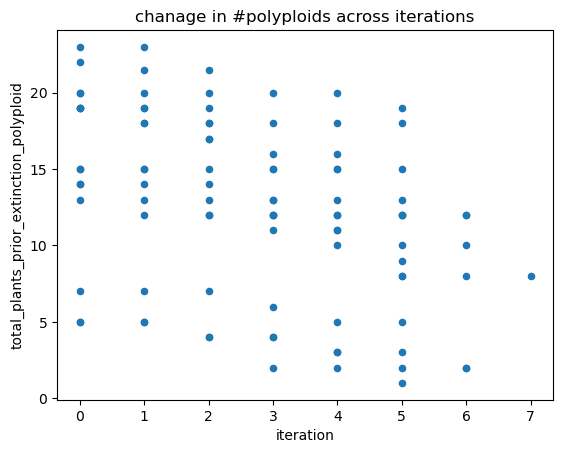

In [68]:
debug_db_grouped.query("max_iteration >= 5 and rate_range == '(0.6, 1)' and baseline_percent_unknown < 0.4 and baseline_n_plant > 20").plot(x="iteration", y="total_plants_prior_extinction_polyploid", kind="scatter")
plt.title("chanage in #polyploids across iterations")

Text(0.5, 1.0, 'chanage in #diploids across iterations')

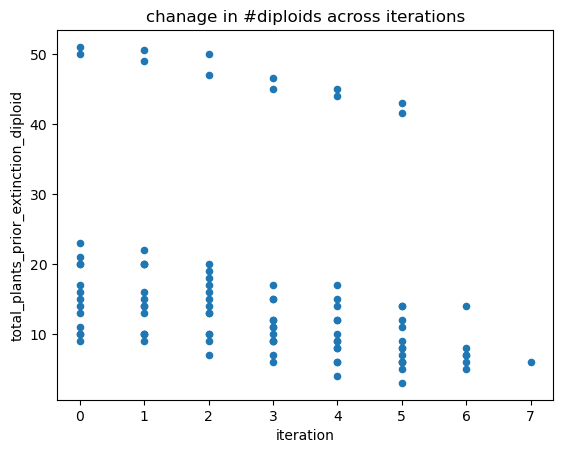

In [69]:
debug_db_grouped.query("max_iteration >= 5 and rate_range == '(0.6, 1)' and baseline_percent_unknown < 0.4 and baseline_n_plant > 20").plot(x="iteration", y="total_plants_prior_extinction_diploid", kind="scatter")
plt.title("chanage in #diploids across iterations")

# games

In [55]:
dataset_simulation_id_to_len = extinction_simulations.query("baseline_percent_polyploids > 0 and iteration > 2").groupby(["network_type",	"rate_range", "network", "simulation_index"])[["iteration", "baseline_n_plant", "baseline_n_polyploids"]].max().reset_index()
dataset_simulation_id_to_len.sort_values(["iteration", "baseline_n_plant", "baseline_n_polyploids"], ascending=[False, False, False], inplace=True)

In [56]:
dataset_simulation_id_to_len.iloc[:30]

,network_type,rate_range,network,simulation_index,iteration,baseline_n_plant,baseline_n_polyploids
477,binarized_weighted,"(0.6, 1)",33,29,9,14,7
3998,weighted,"(0.6, 1)",263,42,9,9,2
1011,binarized_weighted,"(0.6, 1)",184,5,7,58,23
2495,binary,"(0.6, 1)",110,38,7,29,8
3491,weighted,"(0.6, 1)",135,56,7,20,7
3188,weighted,"(0.6, 1)",63,45,7,17,9
1817,binarized_weighted,"(0.6, 1)",392,85,7,13,5
3655,weighted,"(0.6, 1)",172,27,7,12,1
2982,weighted,"(0.6, 1)",17,67,7,11,3
1108,binarized_weighted,"(0.6, 1)",216,96,7,10,3


In [29]:
indexed_extinction_simulations =  extinction_simulations.groupby(["network_type","rate_range", "network", "simulation_index"])

(0.0, 1.0)

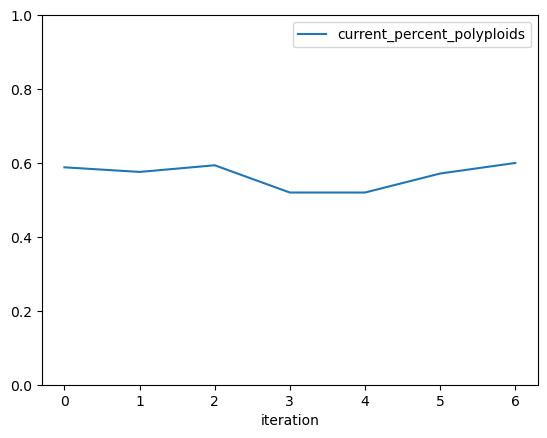

In [57]:
debug_extinction_simulation = indexed_extinction_simulations.get_group(("binarized_weighted","(0.6, 1)",96,97))
debug_extinction_simulation = debug_extinction_simulation.rename(columns={"degree": "iteration"})
debug_extinction_simulation.plot(x="iteration", y="current_percent_polyploids")
plt.ylim(0,1)

(0.0, 1.0)

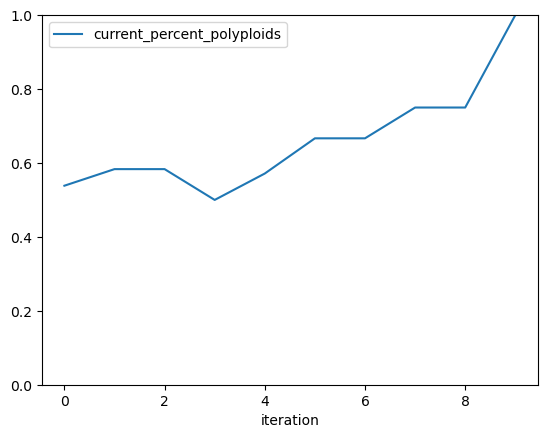

In [49]:
debug_extinction_simulation = indexed_extinction_simulations.get_group(("binarized_weighted","(0.6, 1)",33,29))
debug_extinction_simulation = debug_extinction_simulation.rename(columns={"degree": "iteration"})
debug_extinction_simulation.plot(x="iteration", y="current_percent_polyploids")
plt.ylim(0,1)

(0.0, 1.0)

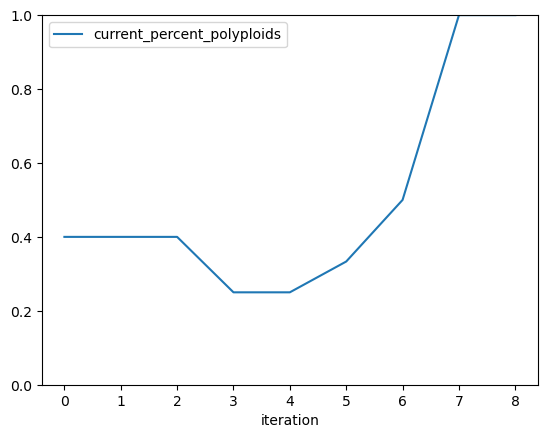

In [50]:
debug_extinction_simulation = indexed_extinction_simulations.get_group(("weighted","(0.6, 1)",263,42))
debug_extinction_simulation.plot(x="iteration", y="current_percent_polyploids")
plt.ylim(0,1)

(0.0, 1.0)

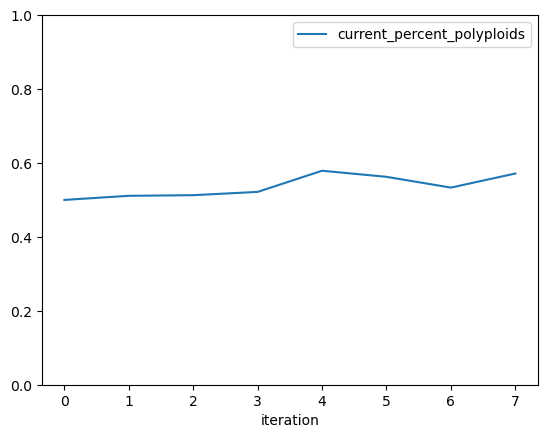

In [51]:
debug_extinction_simulation = indexed_extinction_simulations.get_group(("binarized_weighted","(0.6, 1)",184,5))
debug_extinction_simulation.plot(x="iteration", y="current_percent_polyploids")
plt.ylim(0,1)

(0.0, 1.0)

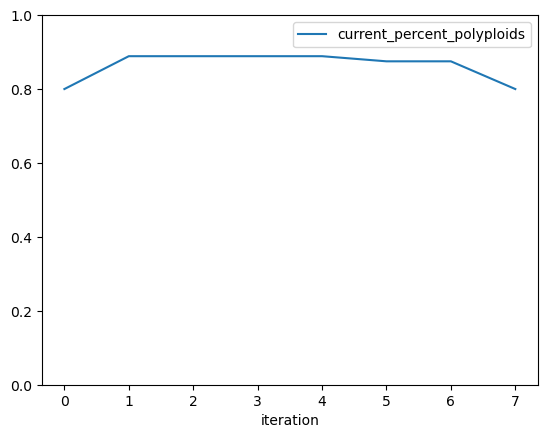

In [52]:
debug_extinction_simulation = indexed_extinction_simulations.get_group(("binary","(0.6, 1)",110,38))
debug_extinction_simulation.plot(x="iteration", y="current_percent_polyploids")
plt.ylim(0,1)

(0.0, 1.0)

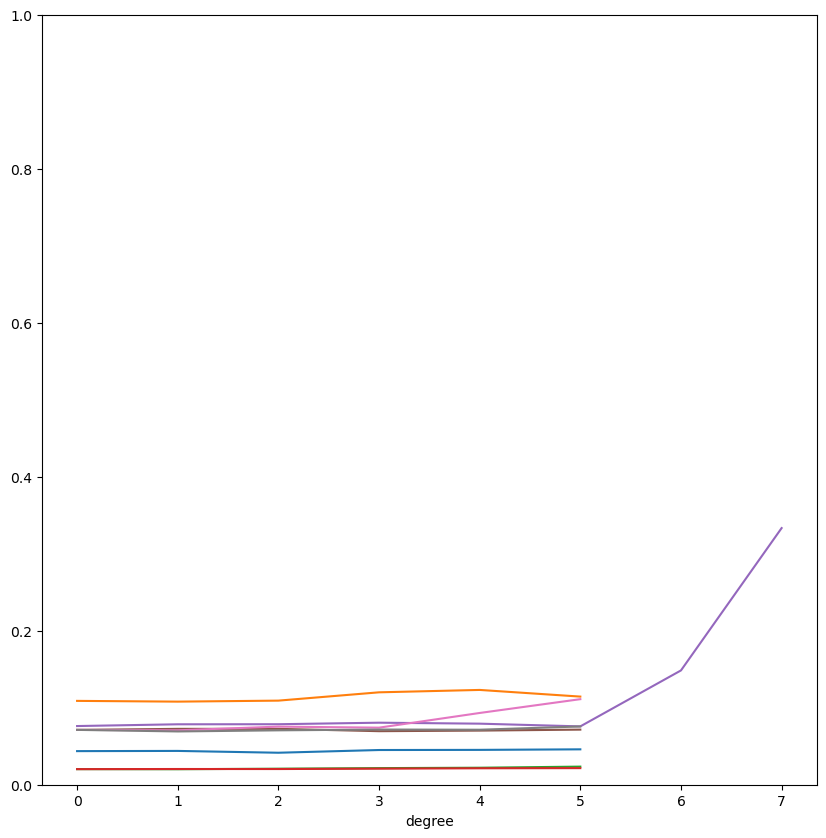

In [191]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10,10))
# debug_db_grouped.plot(x="degree", y="connectence", kind="line", legend=False, ax=ax)
# ax.set_ylim(0, 1)